<a href="https://colab.research.google.com/github/mavillan/gb-vpp/blob/main/models/gb-vpp-lstm-gru-stk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
import tensorflow as tf

if tf.__version__ != '2.4.3':
    !pip uninstall -y tensorflow 
    !pip install tensorflow==2.4.3 > /dev/null 2>&1
!pip install tensorflow-addons > /dev/null 2>&1
!pip install --upgrade pandas > /dev/null 2>&1

print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

import os
from tensorflow.python.profiler import profiler_client
#tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
#print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

Tensorflow version 2.4.3
INFO:tensorflow:Initializing the TPU system: grpc://10.48.140.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.48.140.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.48.140.114:8470']


In [3]:
!mkdir -p input/
!kaggle competitions download -c ventilator-pressure-prediction -p input/ --force

!unzip -o input/sample_submission.csv.zip -d input/
!unzip -o input/train.csv.zip -d input/
!unzip -o input/test.csv.zip -d input/

 88% 66.0M/75.4M [00:00<00:00, 89.2MB/s]
100% 75.4M/75.4M [00:00<00:00, 118MB/s] 
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 78.1MB/s]
100% 139M/139M [00:00<00:00, 137MB/s]

Archive:  input/sample_submission.csv.zip
  inflating: input/sample_submission.csv  
Archive:  input/train.csv.zip
  inflating: input/train.csv         
Archive:  input/test.csv.zip
  inflating: input/test.csv          


In [4]:
input_path = "input"
subs_path = "/content/drive/MyDrive/kaggle/gb-vpp/subs"
results_path = "/content/drive/MyDrive/kaggle/gb-vpp/results"
artifacts_path = "/content/drive/MyDrive/kaggle/gb-vpp/artifacts"

In [5]:
!kaggle datasets download --unzip --force -d mavillan/gb-vpp-folds-split
#!kaggle datasets download --unzip --force -d markpeng/lightning-unsupervised-tst

 52% 6.00M/11.5M [00:00<00:00, 60.1MB/s]
100% 11.5M/11.5M [00:00<00:00, 73.7MB/s]


In [6]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        721M        7.9G        1.1M        4.1G         11G
Swap:            0B          0B          0B


***

In [7]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

import sys
sys.path.append("/content/drive/MyDrive/kaggle")
from gauss_rank_scaler import GaussRankScaler

In [8]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

***
## data preparation

In [9]:
class config:
    # data params
    SEQ_LEN = 32

    # train params
    EPOCHS = 300
    BATCH_SIZE = 512
    # for ReduceLROnPlateu
    SCHEDULER_PATIENCE = 10
    SCHEDULER_FACTOR = 0.8
    STOPPING_PATIENCE = 35
    # for cyclical schedulers
    INIT_LR = 1e-4
    MAX_LR = 1e-3
    
    # others
    MODEL_ID = "lstm-gru-stk"
    DEBUG = False
    
if config.DEBUG:
    config.EPOCHS = 2

In [10]:
with open("./split_10folds_seed19.pkl", "rb") as file:
    split = pickle.load(file)

In [11]:
train_raw = reduce_mem_usage(pd.read_csv(f'{input_path}/train.csv'), verbose=True)
test_raw = reduce_mem_usage(pd.read_csv(f'{input_path}/test.csv'), verbose=True)
submission = pd.read_csv(f'{input_path}/sample_submission.csv')

gc.collect()

Mem. usage decreased to 132.40 Mb (64.1% reduction)
Mem. usage decreased to 72.91 Mb (66.1% reduction)


22

In [12]:
PRESSURE_VALUES = np.sort(train_raw.pressure.unique())

PRESSURE_MIN = train_raw.pressure.min()
PRESSURE_MAX = train_raw.pressure.max()
PRESSURE_STEP = PRESSURE_VALUES[1]-PRESSURE_VALUES[0]

def discretize_pressure(pressure_array):
    pressure_array = np.clip(pressure_array, PRESSURE_MIN, PRESSURE_MAX)
    discrete = np.round( (pressure_array - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
    return discrete

def pressure_to_idx(array):
    return ((array - PRESSURE_MIN) / PRESSURE_STEP).astype(int)

def idx_to_pressure(array):
    return (array * PRESSURE_STEP) + PRESSURE_MIN

In [13]:
# load oof preds
oof1 = pd.read_csv(f"{results_path}/oof_lstm-gru-2h.csv", index_col=0)[["id","pred"]].rename({"pred":"pred1"}, axis=1)
oof1["pred1"] = discretize_pressure(oof1.pred1.values)

oof2 = pd.read_csv(f"{results_path}/oof_lstm-gru-tangle-2h.csv")[["id","pred"]].rename({"pred":"pred2"}, axis=1)
oof2["pred2"] = discretize_pressure(oof2.pred2.values)

# load model preds (8 folds)
sub1 = pd.read_csv(f"{subs_path}/sub_lstm-gru-2h_clip.csv").rename({"pressure":"pred1"}, axis=1)
sub2 = pd.read_csv(f"{subs_path}/sub_lstm-gru-tangle-2h_clip.csv").rename({"pressure":"pred2"}, axis=1)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [14]:
assert (train_raw.id == oof1.id).all()
assert (train_raw.id == oof2.id).all()
train_raw["pred1"] = oof1["pred1"].values
train_raw["pred2"] = oof2["pred2"].values

assert (test_raw.id == sub1.id).all()
assert (test_raw.id == sub2.id).all()
test_raw["pred1"] = sub1["pred1"].values
test_raw["pred2"] = sub2["pred2"].values

In [15]:
mapping = {j:i for i,j in enumerate(train_raw.breath_id.unique())}
train_raw["breath_id"] = train_raw.breath_id.map(mapping)

if config.SEQ_LEN < 80:

    train_raw = (
        train_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(config.SEQ_LEN)
        .reset_index(drop=True)
    )
    test_raw = (
        test_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(config.SEQ_LEN)
        .reset_index(drop=True)
    )

In [16]:
def compute_feats(df):

    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] = df['u_in_cumsum'] / (df.groupby("breath_id")["id"].cumcount()+1)
    df['u_in_max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['u_in_diffmax'] = df["u_in_max"] - df['u_in']

    df["time_diff"] = df.groupby("breath_id")["time_step"].diff()
    df['vol_diff'] = (df['time_diff']*df['u_in']).fillna(0)
    df['vol_diff_cumsum'] = df.groupby('breath_id')['vol_diff'].cumsum()
    df["time_diff"] = df["time_diff"].fillna(method="bfill")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_in_lag5'] = df.groupby('breath_id')['u_in'].shift(5)
    df['u_in_lag6'] = df.groupby('breath_id')['u_in'].shift(6)
    df['u_in_lag7'] = df.groupby('breath_id')['u_in'].shift(7)
    df['u_in_lag8'] = df.groupby('breath_id')['u_in'].shift(8)
    df['u_in_lag9'] = df.groupby('breath_id')['u_in'].shift(9)
    df['u_in_lag10'] = df.groupby('breath_id')['u_in'].shift(10)
    df = df.fillna(0)

    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_in_diff5'] = df['u_in'] - df['u_in_lag5']
    df['u_in_diff6'] = df['u_in'] - df['u_in_lag6']
    df['u_in_diff7'] = df['u_in'] - df['u_in_lag7']
    df['u_in_diff8'] = df['u_in'] - df['u_in_lag8']
    df['u_in_diff9'] = df['u_in'] - df['u_in_lag9']
    df['u_in_diff10'] = df['u_in'] - df['u_in_lag10']

    df['ewm_u_in_mean'] = (
        df
        .groupby('breath_id')['u_in']
        .ewm(halflife=9)
        .mean()
        .reset_index(level=0,drop=True)
    )

    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df = pd.get_dummies(df)
    
    return df

print("Train data...\n")
train = compute_feats(train_raw)
train = reduce_mem_usage(train, verbose=True)
print("\nTest data...\n")
test = compute_feats(test_raw)
test = reduce_mem_usage(test, verbose=True)

del train_raw,test_raw
gc.collect()

Train data...

Mem. usage decreased to 338.48 Mb (9.8% reduction)

Test data...

Mem. usage decreased to 219.51 Mb (7.7% reduction)


0

In [17]:
targets = train[['pressure']].to_numpy().reshape(-1, config.SEQ_LEN)
mask_out = train[["u_out"]].to_numpy().reshape(-1, config.SEQ_LEN)
mask_in = 1-mask_out

oof = train[["id","breath_id","u_out","pressure"]].copy()
test_raw = test[["id"]].copy()

cols_to_exclude_train = [
    'pressure','id', 'breath_id', 'u_out'
]
cols_to_exclude_test = [
    'id', 'breath_id', 'u_out'
]

train.drop(cols_to_exclude_train, axis=1, inplace=True)
test.drop(cols_to_exclude_test, axis=1, inplace=True)

train.insert(0, "u_in", train.pop("u_in").values)
test.insert(0, "u_in", test.pop("u_in").values)

assert (train.columns == test.columns).all()

In [18]:
categorical_cols = [
    "R_5","R_20","R_50",
    "C_10","C_20","C_50",
]
numerical_cols = list(set(train.columns) - set(categorical_cols))

In [19]:
merged = pd.concat([train[numerical_cols], test[numerical_cols]], axis=0, ignore_index=True)

scaler = RobustScaler()
#scaler = GaussRankScaler()
scaler.fit(merged.values)

train[numerical_cols] = scaler.transform(train[numerical_cols].values)
test[numerical_cols] = scaler.transform(test[numerical_cols].values)

In [20]:
train = train.values.reshape(-1, config.SEQ_LEN, train.shape[1])
test =  test.values.reshape(-1, config.SEQ_LEN, train.shape[2])

***

In [22]:
def masked_l1_loss(y_true, y_pred, mask):
    return tf.keras.losses.mae(tf.boolean_mask(y_true, mask), tf.boolean_mask(y_pred, mask))

class LSTMGRU2Heads(tf.keras.Model):

    def __init__(self):
        super(LSTMGRU2Heads, self).__init__()

        self.noise_level = 1.0

        # feature extrators on u_in
        self.conv1 = layers.Conv1D(32, 5, padding="same", activation='tanh')
        
        self.lstm1 = layers.Bidirectional(layers.LSTM(units=768, return_sequences=True, recurrent_dropout=0.))
        self.lstm2 = layers.Bidirectional(layers.LSTM(units=512, return_sequences=True, recurrent_dropout=0.))
        self.lstm3 = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True, recurrent_dropout=0.))
        self.lstm4 = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True, recurrent_dropout=0.))

        self.gru1 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, recurrent_dropout=0.1))
        self.gru2 = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, recurrent_dropout=0.1))
        self.gru3 = layers.Bidirectional(layers.GRU(units=64, return_sequences=True,  recurrent_dropout=0.1))

        self.dense1 = tfa.layers.WeightNormalization(layers.Dense(units=128, activation='selu',))
        self.head1 = tfa.layers.WeightNormalization(layers.Dense(units=1))
        
        self.tracker_loss = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        
        # features extracted over u_in with conv layers
        u_in = tf.expand_dims(inputs[:,:,0], axis=-1)
        u_in_k5 = self.conv1(u_in)

        x = tf.concat([inputs, u_in_k5], axis=-1)

        x1 = self.lstm1(x)
        x2 = self.lstm2(x1)
        x3 = self.lstm3(x2)
        x4 = self.lstm4(x3)
        
        z2 = self.gru1(x2)
        z3 = self.gru2(x3+z2)
        z4 = self.gru3(x4+z3)
        
        x = tf.concat([x4, z2, z3, z4], axis=-1)
        x = self.dense1(x)
        
        output_in = self.head1(x)
        return output_in

    def train_step(self, data):
        X,y = data
        x,mask_in,_ = X

        with tf.GradientTape() as tape:
            y_pred_in = self(x, training=True)
            y_pred_in = tf.squeeze(y_pred_in)
            # compute the loss value
            noise = tf.random.truncated_normal(
                tf.shape(y), 
                mean=0.0, 
                stddev=self.noise_level*PRESSURE_STEP, 
                dtype=tf.dtypes.float32, 
                seed=2,
              )
            loss_l1 = masked_l1_loss(y+noise, y_pred_in, mask_in)
            loss_reg = tf.math.reduce_sum(self.losses)
            loss = loss_l1 + loss_reg

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update metrics (includes the metric that tracks the loss)
        self.tracker_loss.update_state(loss)

        return {
            "loss": self.tracker_loss.result(), 
        }

    @property
    def metrics(self):
        return [self.tracker_loss,]

    def test_step(self, data):
        X,y = data
        x,mask_in,_ = X
        # compute predictions
        y_pred_in = self(x, training=False)
        y_pred_in = tf.squeeze(y_pred_in)
        # compute loss
        loss = masked_l1_loss(y, y_pred_in, mask_in)
        # updates the metrics
        self.tracker_loss.update_state(loss)
        
        return {
            "loss": self.tracker_loss.result(),
        }

    def predict_step(self, data):
        y_pred_in = self(data, training=False)
        return y_pred_in

----------------------------------- Fold: 1 ------------------------------------
Epoch 1/300
133/133 [==============================] - 112s 371ms/step - loss: 2.0355 - val_loss: 0.7462
Epoch 2/300
133/133 [==============================] - 13s 99ms/step - loss: 0.6891 - val_loss: 0.6332
Epoch 3/300
133/133 [==============================] - 12s 91ms/step - loss: 0.5314 - val_loss: 0.4292
Epoch 4/300
133/133 [==============================] - 12s 91ms/step - loss: 0.4887 - val_loss: 0.4346
Epoch 5/300
133/133 [==============================] - 12s 92ms/step - loss: 0.4213 - val_loss: 0.5265
Epoch 6/300
133/133 [==============================] - 12s 92ms/step - loss: 0.3945 - val_loss: 0.3303
Epoch 7/300
133/133 [==============================] - 12s 92ms/step - loss: 0.3702 - val_loss: 0.3277
Epoch 8/300
133/133 [==============================] - 12s 92ms/step - loss: 0.4094 - val_loss: 0.2679
Epoch 9/300
133/133 [==============================] - 12s 92ms/step - loss: 0.2804 - val_los

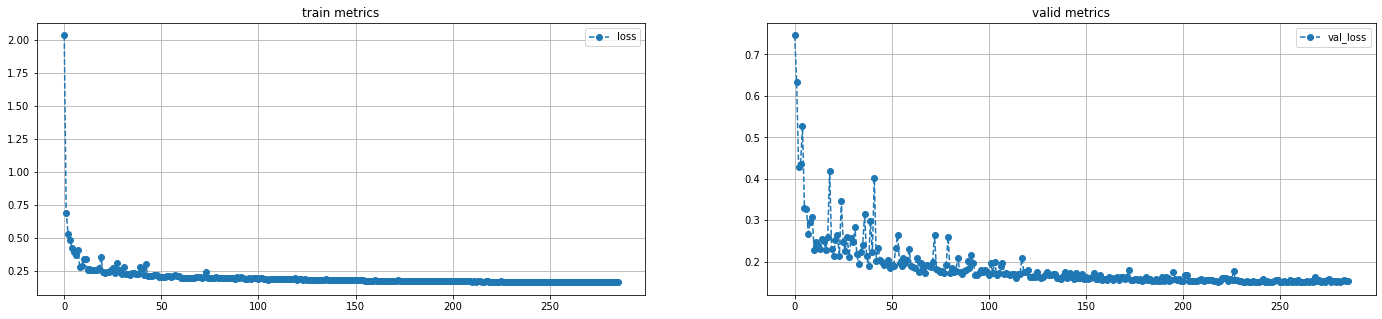

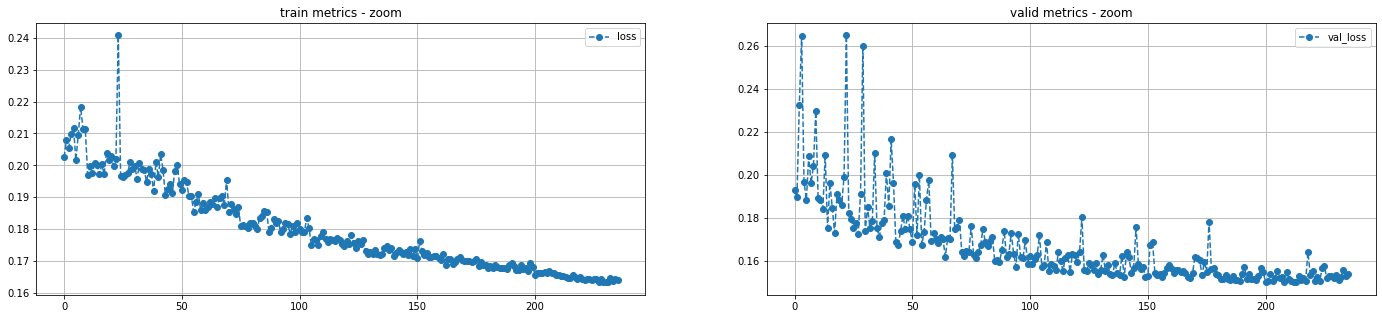

----------------------------------- Fold: 2 ------------------------------------
Epoch 1/300
133/133 [==============================] - 94s 359ms/step - loss: 1.9859 - val_loss: 1.0399
Epoch 2/300
133/133 [==============================] - 12s 92ms/step - loss: 0.7118 - val_loss: 0.5216
Epoch 3/300
133/133 [==============================] - 12s 93ms/step - loss: 0.5534 - val_loss: 0.4093
Epoch 4/300
133/133 [==============================] - 12s 93ms/step - loss: 0.4925 - val_loss: 0.4271
Epoch 5/300
133/133 [==============================] - 12s 92ms/step - loss: 0.4161 - val_loss: 0.5022
Epoch 6/300
133/133 [==============================] - 12s 93ms/step - loss: 0.3869 - val_loss: 0.3162
Epoch 7/300
133/133 [==============================] - 12s 93ms/step - loss: 0.3404 - val_loss: 0.3194
Epoch 8/300
133/133 [==============================] - 13s 97ms/step - loss: 0.3273 - val_loss: 0.2568
Epoch 9/300
133/133 [==============================] - 12s 93ms/step - loss: 0.3228 - val_loss

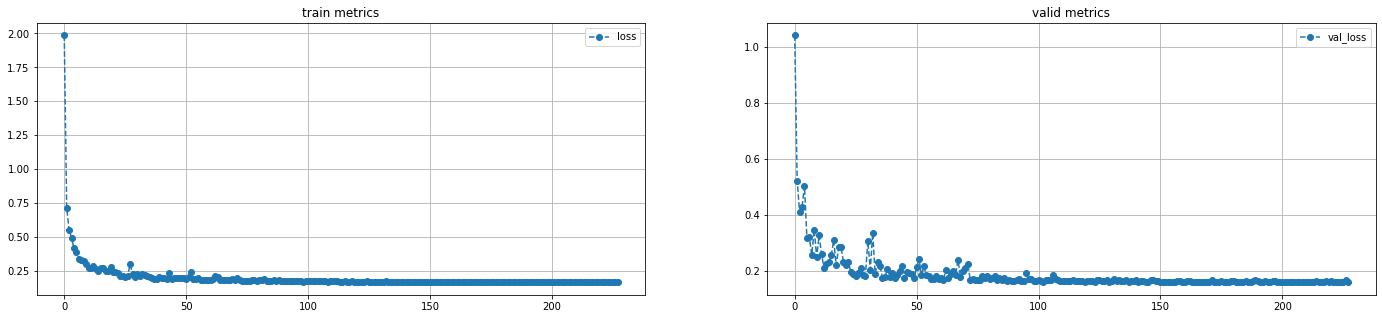

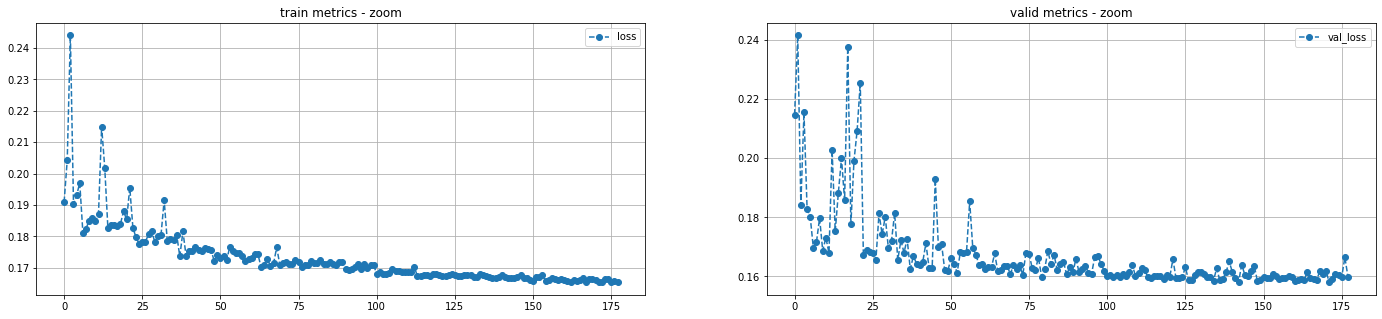

----------------------------------- Fold: 3 ------------------------------------
Epoch 1/300
133/133 [==============================] - 94s 363ms/step - loss: 2.0756 - val_loss: 0.9268
Epoch 2/300
133/133 [==============================] - 12s 93ms/step - loss: 0.8675 - val_loss: 0.7278
Epoch 3/300
133/133 [==============================] - 12s 93ms/step - loss: 0.7659 - val_loss: 0.6935
Epoch 4/300
133/133 [==============================] - 12s 94ms/step - loss: 0.6728 - val_loss: 0.5786
Epoch 5/300
133/133 [==============================] - 12s 93ms/step - loss: 0.6086 - val_loss: 0.5760
Epoch 6/300
133/133 [==============================] - 12s 93ms/step - loss: 0.5674 - val_loss: 0.6152
Epoch 7/300
133/133 [==============================] - 12s 94ms/step - loss: 0.5223 - val_loss: 0.4782
Epoch 8/300
133/133 [==============================] - 12s 93ms/step - loss: 0.5208 - val_loss: 0.5182
Epoch 9/300
133/133 [==============================] - 12s 93ms/step - loss: 0.4911 - val_loss

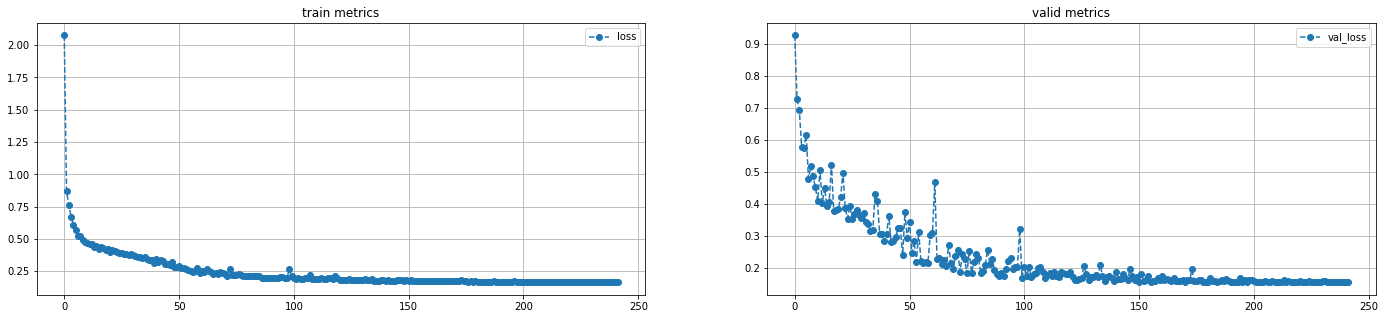

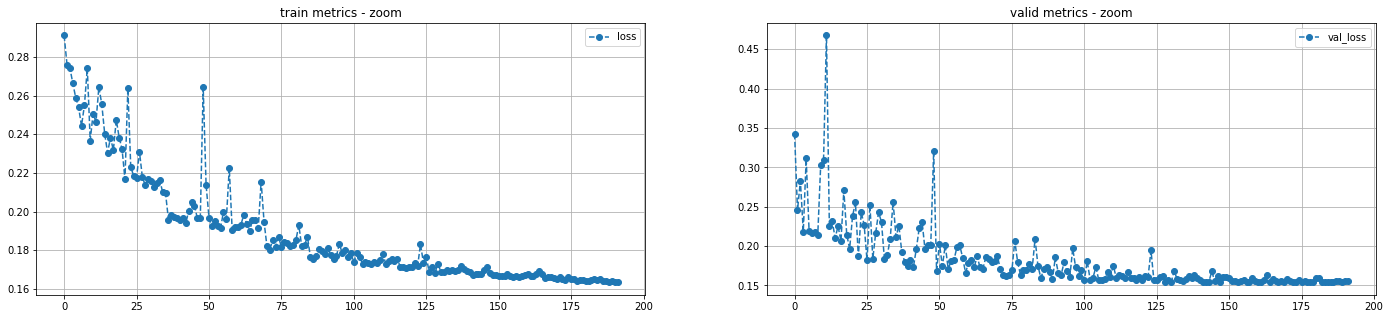

----------------------------------- Fold: 4 ------------------------------------
Epoch 1/300
133/133 [==============================] - 95s 347ms/step - loss: 1.9873 - val_loss: 1.0275
Epoch 2/300
133/133 [==============================] - 12s 94ms/step - loss: 1.0320 - val_loss: 0.9346
Epoch 3/300
133/133 [==============================] - 12s 94ms/step - loss: 0.9058 - val_loss: 0.9344
Epoch 4/300
133/133 [==============================] - 12s 94ms/step - loss: 0.8280 - val_loss: 0.8591
Epoch 5/300
133/133 [==============================] - 13s 95ms/step - loss: 0.7673 - val_loss: 0.7128
Epoch 6/300
133/133 [==============================] - 13s 94ms/step - loss: 0.6748 - val_loss: 0.6022
Epoch 7/300
133/133 [==============================] - 13s 94ms/step - loss: 0.6758 - val_loss: 0.6464
Epoch 8/300
133/133 [==============================] - 12s 94ms/step - loss: 0.6219 - val_loss: 0.5058
Epoch 9/300
133/133 [==============================] - 12s 94ms/step - loss: 0.6066 - val_loss

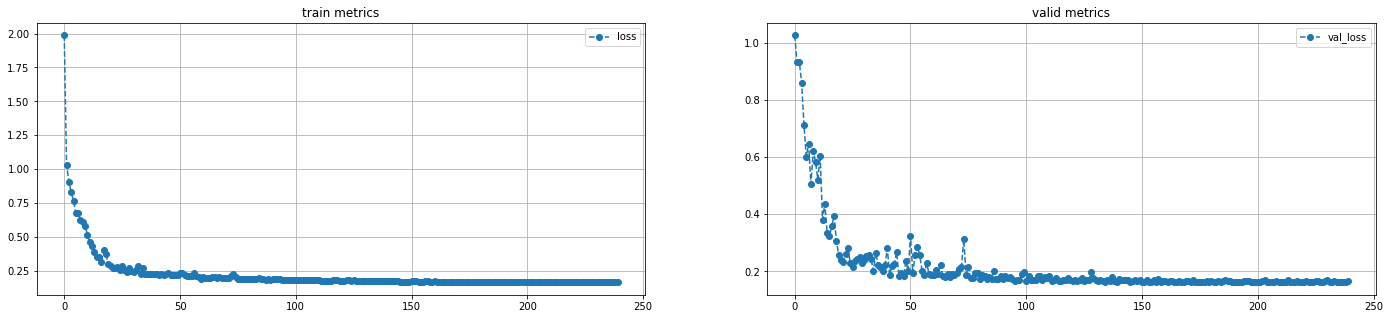

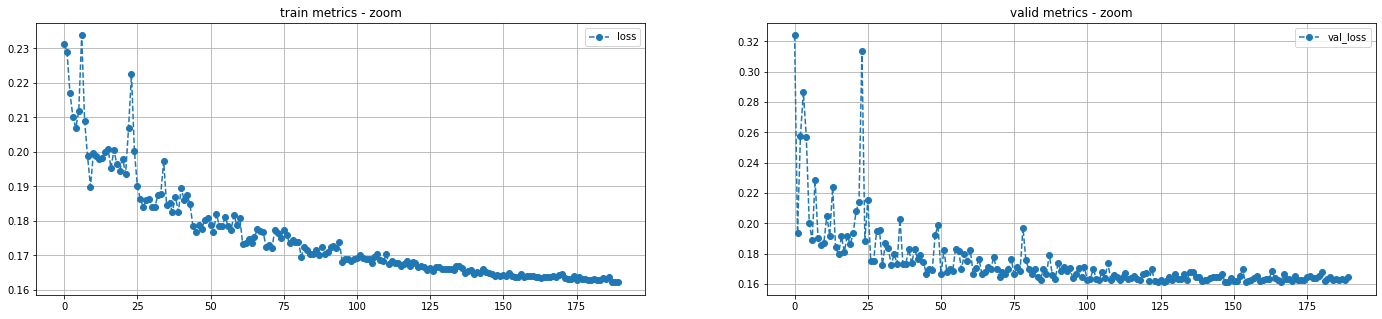

----------------------------------- Fold: 5 ------------------------------------
Epoch 1/300
133/133 [==============================] - 94s 363ms/step - loss: 2.5529 - val_loss: 1.3736
Epoch 2/300
133/133 [==============================] - 12s 93ms/step - loss: 1.1893 - val_loss: 1.0879
Epoch 3/300
133/133 [==============================] - 12s 94ms/step - loss: 0.8729 - val_loss: 0.7495
Epoch 4/300
133/133 [==============================] - 12s 94ms/step - loss: 0.7534 - val_loss: 0.5363
Epoch 5/300
133/133 [==============================] - 13s 94ms/step - loss: 0.6009 - val_loss: 0.4543
Epoch 6/300
133/133 [==============================] - 13s 94ms/step - loss: 0.5186 - val_loss: 0.4767
Epoch 7/300
133/133 [==============================] - 12s 94ms/step - loss: 0.4906 - val_loss: 0.4971
Epoch 8/300
133/133 [==============================] - 13s 94ms/step - loss: 0.4782 - val_loss: 0.3971
Epoch 9/300
133/133 [==============================] - 12s 94ms/step - loss: 0.4355 - val_loss

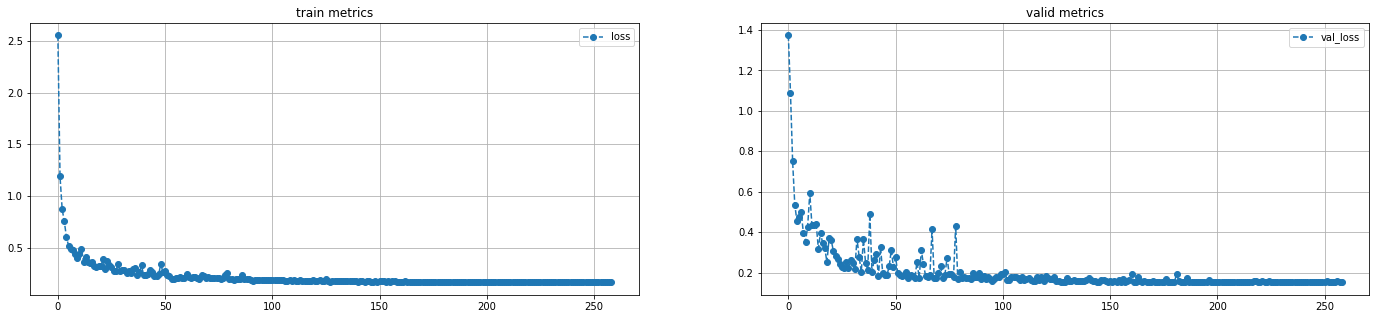

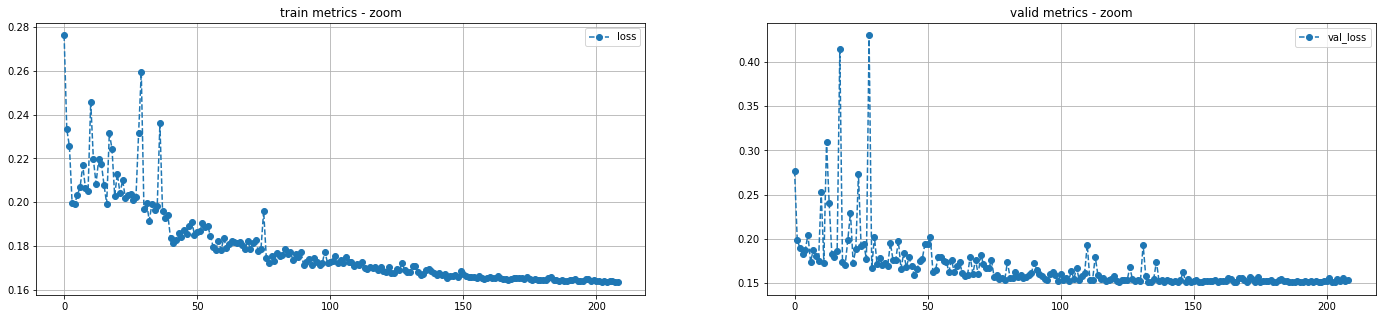

----------------------------------- Fold: 6 ------------------------------------
Epoch 1/300
133/133 [==============================] - 97s 355ms/step - loss: 2.3533 - val_loss: 1.1223
Epoch 2/300
133/133 [==============================] - 12s 94ms/step - loss: 0.9367 - val_loss: 0.8272
Epoch 3/300
133/133 [==============================] - 13s 95ms/step - loss: 0.7374 - val_loss: 0.7995
Epoch 4/300
133/133 [==============================] - 12s 94ms/step - loss: 0.6549 - val_loss: 0.7438
Epoch 5/300
133/133 [==============================] - 13s 94ms/step - loss: 0.5260 - val_loss: 0.4768
Epoch 6/300
133/133 [==============================] - 13s 95ms/step - loss: 0.5113 - val_loss: 0.3725
Epoch 7/300
133/133 [==============================] - 13s 94ms/step - loss: 0.4151 - val_loss: 0.4391
Epoch 8/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3995 - val_loss: 0.3093
Epoch 9/300
133/133 [==============================] - 13s 95ms/step - loss: 0.4674 - val_loss

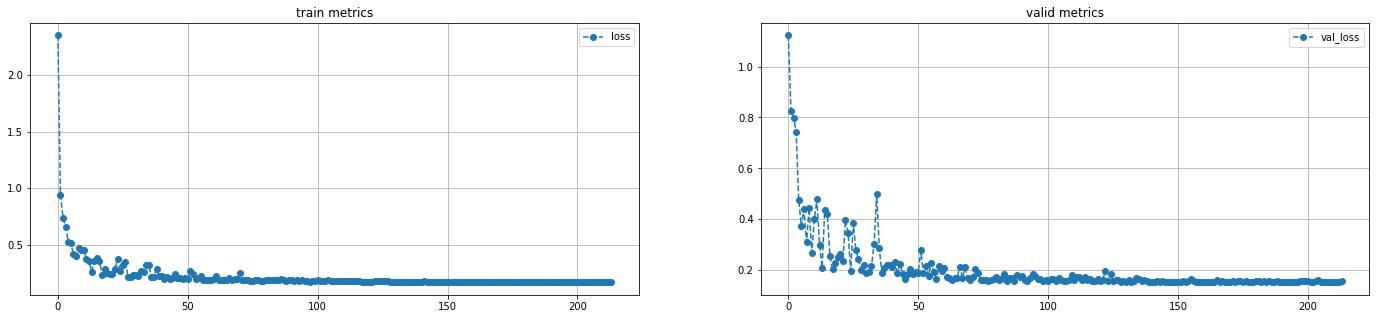

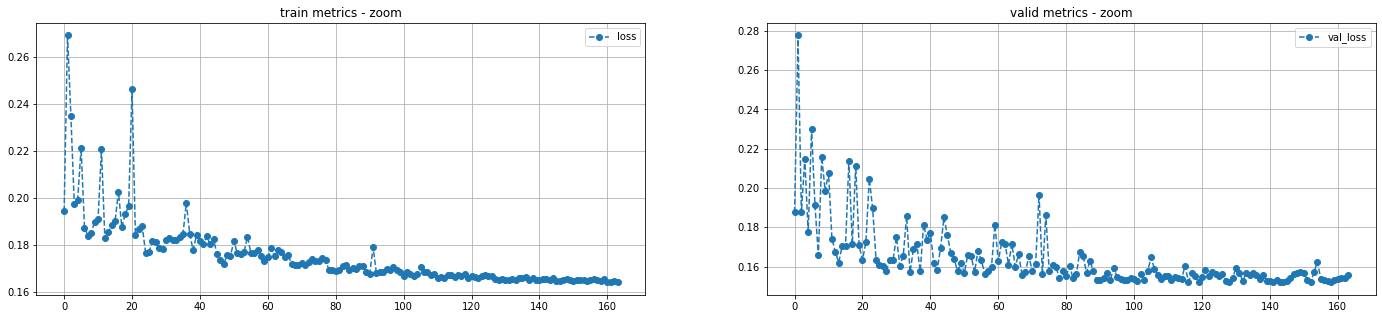

----------------------------------- Fold: 7 ------------------------------------
Epoch 1/300
133/133 [==============================] - 97s 361ms/step - loss: 1.8637 - val_loss: 0.8419
Epoch 2/300
133/133 [==============================] - 12s 94ms/step - loss: 0.6426 - val_loss: 0.5215
Epoch 3/300
133/133 [==============================] - 12s 94ms/step - loss: 0.5437 - val_loss: 0.4048
Epoch 4/300
133/133 [==============================] - 13s 94ms/step - loss: 0.4398 - val_loss: 0.4167
Epoch 5/300
133/133 [==============================] - 12s 94ms/step - loss: 0.4324 - val_loss: 0.4188
Epoch 6/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3771 - val_loss: 0.3373
Epoch 7/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3632 - val_loss: 0.3422
Epoch 8/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3590 - val_loss: 0.3199
Epoch 9/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3425 - val_loss

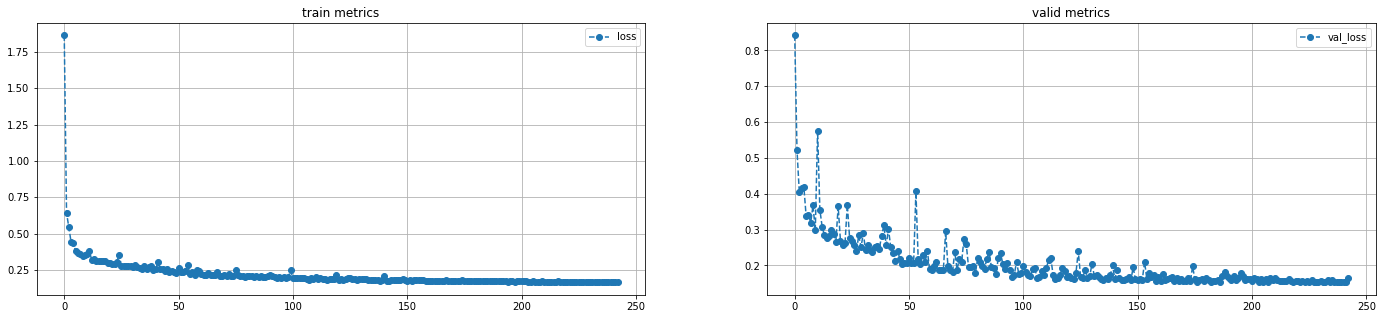

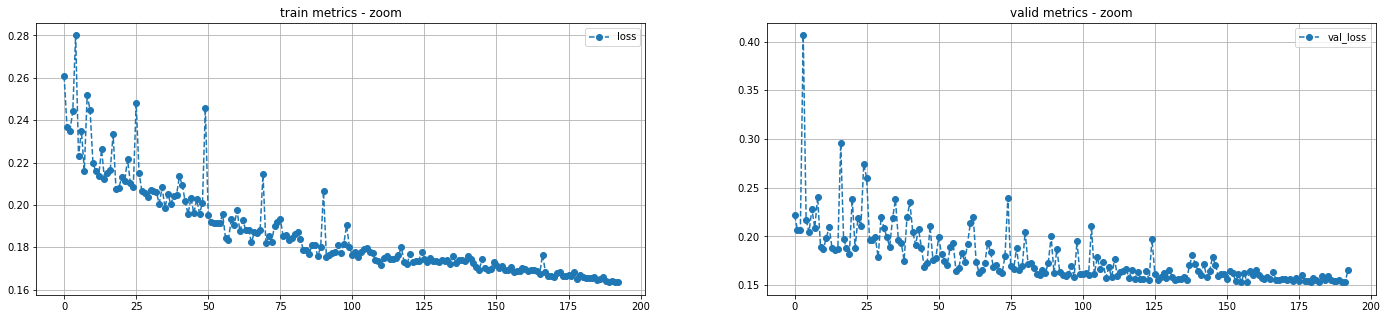

----------------------------------- Fold: 8 ------------------------------------
Epoch 1/300
133/133 [==============================] - 93s 366ms/step - loss: 1.9685 - val_loss: 0.8366
Epoch 2/300
133/133 [==============================] - 12s 94ms/step - loss: 0.7989 - val_loss: 0.6873
Epoch 3/300
133/133 [==============================] - 15s 114ms/step - loss: 0.6465 - val_loss: 0.6542
Epoch 4/300
133/133 [==============================] - 13s 95ms/step - loss: 0.5471 - val_loss: 0.6747
Epoch 5/300
133/133 [==============================] - 13s 94ms/step - loss: 0.5025 - val_loss: 0.3886
Epoch 6/300
133/133 [==============================] - 12s 94ms/step - loss: 0.4243 - val_loss: 0.3454
Epoch 7/300
133/133 [==============================] - 13s 94ms/step - loss: 0.4106 - val_loss: 0.3792
Epoch 8/300
133/133 [==============================] - 13s 95ms/step - loss: 0.4162 - val_loss: 0.4739
Epoch 9/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3755 - val_los

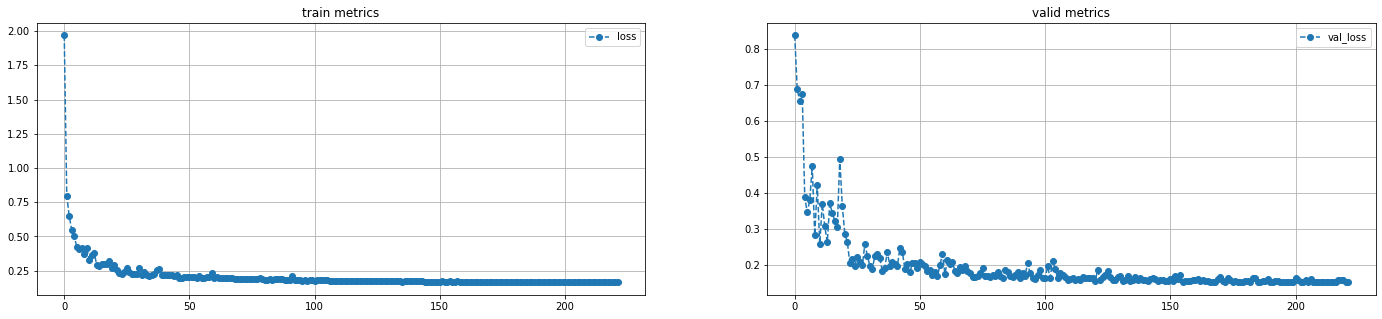

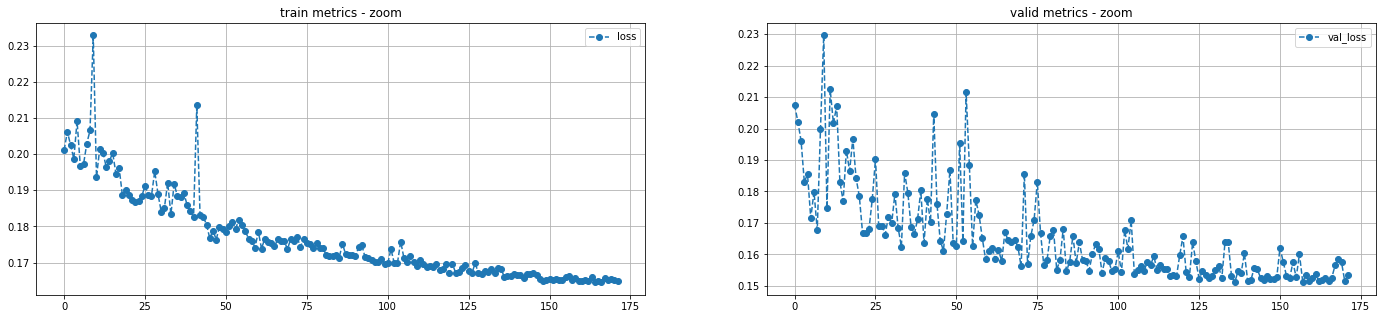

----------------------------------- Fold: 9 ------------------------------------
Epoch 1/300
133/133 [==============================] - 93s 357ms/step - loss: 2.0667 - val_loss: 1.0808
Epoch 2/300
133/133 [==============================] - 12s 94ms/step - loss: 0.9132 - val_loss: 0.8547
Epoch 3/300
133/133 [==============================] - 13s 94ms/step - loss: 0.6827 - val_loss: 0.7743
Epoch 4/300
133/133 [==============================] - 13s 94ms/step - loss: 0.5378 - val_loss: 0.4422
Epoch 5/300
133/133 [==============================] - 13s 94ms/step - loss: 0.4578 - val_loss: 0.3630
Epoch 6/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3928 - val_loss: 0.3312
Epoch 7/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3833 - val_loss: 0.3689
Epoch 8/300
133/133 [==============================] - 13s 95ms/step - loss: 0.3460 - val_loss: 0.2907
Epoch 9/300
133/133 [==============================] - 13s 94ms/step - loss: 0.3581 - val_loss

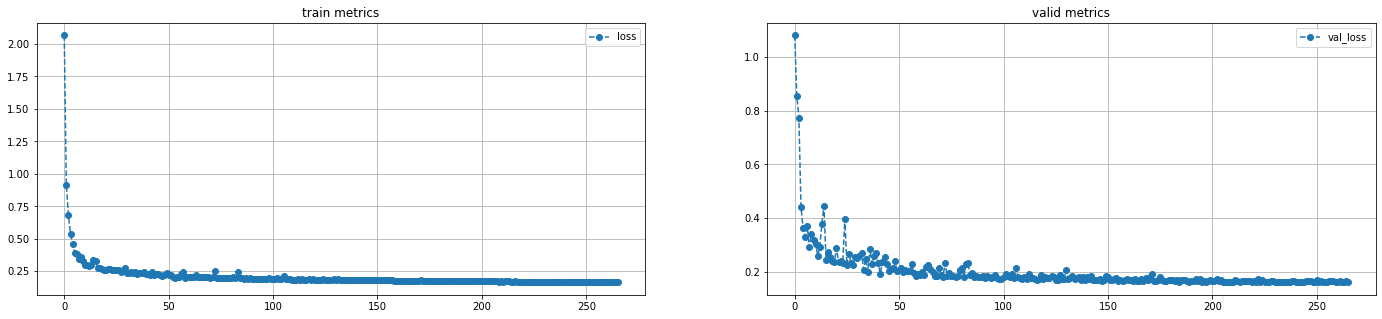

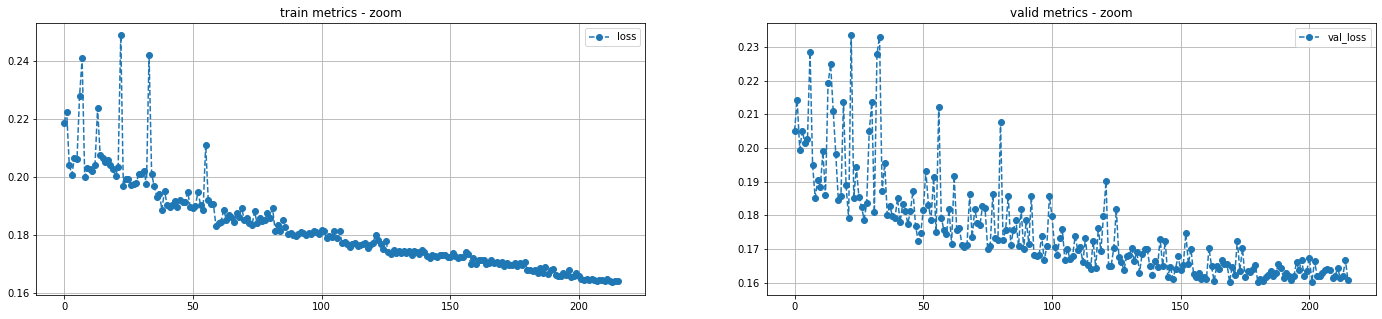

----------------------------------- Fold: 10 -----------------------------------
Epoch 1/300
133/133 [==============================] - 97s 369ms/step - loss: 1.8389 - val_loss: 0.7025
Epoch 2/300
133/133 [==============================] - 13s 95ms/step - loss: 0.6242 - val_loss: 0.5230
Epoch 3/300
133/133 [==============================] - 13s 95ms/step - loss: 0.5437 - val_loss: 0.4180
Epoch 4/300
133/133 [==============================] - 13s 96ms/step - loss: 0.5458 - val_loss: 0.4791
Epoch 5/300
133/133 [==============================] - 13s 95ms/step - loss: 0.4478 - val_loss: 0.3185
Epoch 6/300
133/133 [==============================] - 13s 96ms/step - loss: 0.3550 - val_loss: 0.3145
Epoch 7/300
133/133 [==============================] - 13s 97ms/step - loss: 0.3620 - val_loss: 0.2853
Epoch 8/300
133/133 [==============================] - 13s 95ms/step - loss: 0.3326 - val_loss: 0.3460
Epoch 9/300
133/133 [==============================] - 13s 96ms/step - loss: 0.4098 - val_loss

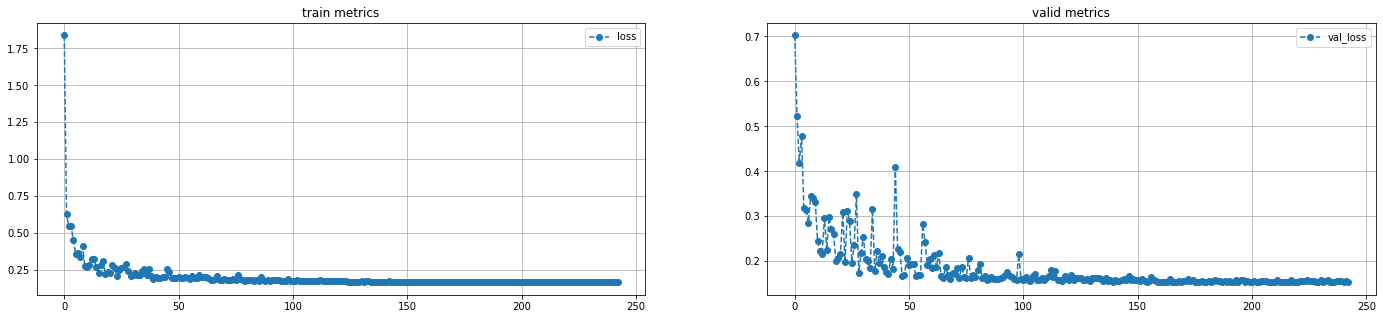

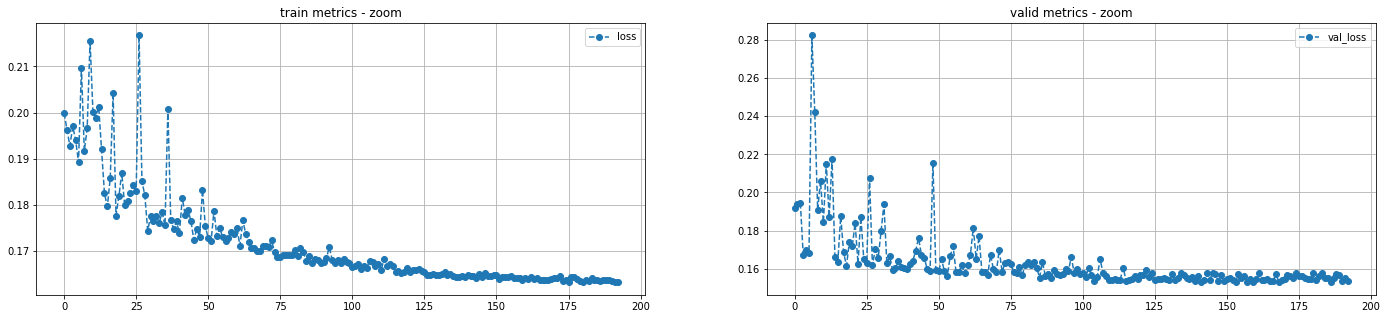

In [23]:
models_by_fold = list()

for fold in range(len(split)):
    print(f" Fold: {fold+1} ".center(80, "-"))
    
    train_idx = split[f"fold-{fold}"]["train"]
    valid_idx = split[f"fold-{fold}"]["valid"]

    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = targets[train_idx], targets[valid_idx]

    mask_in_train, mask_in_valid = mask_in[train_idx], mask_in[valid_idx]
    mask_out_train, mask_out_valid = mask_out[train_idx], mask_out[valid_idx]

    model_path = f"{artifacts_path}/{config.MODEL_ID}_fold{fold}"

    if os.path.isdir(model_path):
        print("Found an already trained model!")
        with tpu_strategy.scope():
            model = LSTMGRU2Heads()
            load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
            model.load_weights(model_path, options=load_locally)
        do_train = False
    else:
        do_train = True

    if do_train:

        lr = ReduceLROnPlateau(
            monitor="val_loss", 
            factor=config.SCHEDULER_FACTOR, 
            patience=config.SCHEDULER_PATIENCE, 
            verbose=1,
            min_lr=1e-4,
            min_delta=0.0001,
        )
        es = EarlyStopping(
            monitor='val_loss', 
            mode='min', 
            patience=config.STOPPING_PATIENCE, 
            min_delta=0.0001,
            verbose=1,
            restore_best_weights=True,
        )

        with tpu_strategy.scope():
            model = LSTMGRU2Heads()
            optimizer = tf.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=optimizer,)

            history = model.fit(
                [X_train,mask_in_train,mask_out_train], 
                y_train, 
                validation_data=([X_valid,mask_in_valid,mask_out_valid], y_valid), 
                epochs=config.EPOCHS,
                batch_size=config.BATCH_SIZE, 
                callbacks=[es,lr],
                shuffle=True,
                verbose=1,
            )

        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        model.save_weights(model_path, options=save_locally, overwrite=True, save_format="tf")
        
        # metrics from epoch 0 ->
        plt.figure(figsize=(24,5))
        plt.subplot(1,2,1)
        plt.title("train metrics")
        plt.plot(history.history["loss"], "o--", label="loss")
        #plt.plot(history.history["mae_in"], "o--", label="mae_in")
        #plt.plot(history.history["mae_out"], "o--", label="mae_out")
        plt.grid()
        plt.legend(loc="best")

        plt.subplot(1,2,2)
        plt.title("valid metrics")
        plt.plot(history.history["val_loss"], "o--", label="val_loss")
        #plt.plot(history.history["val_mae_in"], "o--", label="val_mae_in")
        #plt.plot(history.history["val_mae_out"], "o--", label="val_mae_out")
        plt.grid()
        plt.legend(loc="best")
        plt.show()

        # metrics from epoch 50 ->
        plt.figure(figsize=(24,5))
        plt.subplot(1,2,1)
        plt.title("train metrics - zoom")
        plt.plot(history.history["loss"][50:], "o--", label="loss")
        #plt.plot(history.history["mae_in"][50:], "o--", label="mae_in")
        #plt.plot(history.history["mae_out"][50:], "o--", label="mae_out")
        plt.grid()
        plt.legend(loc="best")

        plt.subplot(1,2,2)
        plt.title("valid metrics - zoom")
        plt.plot(history.history["val_loss"][50:], "o--", label="val_loss")
        #plt.plot(history.history["val_mae_in"][50:], "o--", label="val_mae_in")
        #plt.plot(history.history["val_mae_out"][50:], "o--", label="val_mae_out")
        plt.grid()
        plt.legend(loc="best")
        plt.show()
    
    # generate the oof predictions
    oof_preds = model(tf.convert_to_tensor(X_valid)).numpy().squeeze()
    idx = oof.query("breath_id in @valid_idx").index
    oof.loc[idx, "pred"] = oof_preds.ravel()
    
    models_by_fold.append(model)

In [25]:
# 0.1580
# best with cyclical: 0.1816
# ReduceLROnPlateu (original features): 0.1640 (epoch 205)
# ReduceLROnPlateu (remove dups): 0.1655 (epoch 232)

Scheduler EXPS:
- **CyclicalLearningRate(1e-4 -> 1e-3, 0.8)** - epoch: 160 - loss: 0.0885 - mae_in: 0.0715 - mae_out: 0.1056 - val_loss: 0.1649 - val_mae_in: 0.1702 - val_mae_out: 0.1596
- **CyclicalLearningRate(1e-5 -> 1e-3, 0.8)** - epoch: 220 - loss: 0.0741 - mae_in: 0.0525 - mae_out: 0.0957 - val_loss: 0.1665 - val_mae_in: 0.1714 - val_mae_out: 0.1616
- **CyclicalLearningRate(1e-4 -> 1e-2, 0.8)** - epoch: 60 - loss: 0.1368 - mae_in: 0.1307 - mae_out: 0.1428 - val_loss: 0.1864 - val_mae_in: 0.2123 - val_mae_out: 0.1605
- **CyclicalLearningRate(1e-4 -> 1e-3, 0.8) plus Conv1D(32,5)** - epoch: 240 - loss: 0.0639 - mae_in: 0.0497 - mae_out: 0.0782 - val_loss: 0.1669 - val_mae_in: 0.1692 - val_mae_out: 0.1646
- **CyclicalLearningRate(1e-4 -> 1e-3, 0.8) plus Conv1D(32,9)** - epoch: 180 - loss: 0.0769 - mae_in: 0.0603 - mae_out: 0.0935 - val_loss: 0.1663 - val_mae_in: 0.1706 - val_mae_out: 0.1619

In [26]:
print("mae:", oof.eval("abs(pressure - pred)").mean())
print("mae inspiratory:", oof.query("u_out == 0").eval("abs(pressure - pred)").mean())
print("mae expiratory :", oof.query("u_out == 1").eval("abs(pressure - pred)").mean())

mae: 0.3400677740573883
mae inspiratory: 0.1528664380311966
mae expiratory : 3.8246097564697266


***
## sub generation

In [29]:
all_preds = list()
test_tf = tf.convert_to_tensor(test, dtype=tf.float32)

for model in tqdm(models_by_fold):
    preds = model(test_tf).numpy().squeeze().ravel()
    all_preds.append(preds)

test_raw["pressure"] = np.median(all_preds, axis=0)

100%|██████████| 10/10 [11:33<00:00, 69.37s/it]


In [30]:
# saves final sub
sub = pd.merge(submission["id"], test_raw[["id","pressure"]], how="left", on="id")
sub["pressure"] = sub["pressure"].fillna(0)
sub.to_csv(f"{subs_path}/sub_{config.MODEL_ID}.csv", index=False)

sub["pressure"] =\
    np.round( (sub.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
sub.pressure = np.clip(sub.pressure, PRESSURE_MIN, PRESSURE_MAX)
sub.to_csv(f"{subs_path}/sub_{config.MODEL_ID}_clip.csv", index=False)

In [31]:
# saves oof preds
oof.to_csv(f"{results_path}/oof_{config.MODEL_ID}.csv", index=False)

In [32]:
# saves each model preds (pseudo labels)
for fold,preds in enumerate(all_preds):
    file_path = f"{results_path}/predictions_{config.MODEL_ID}_{fold}.csv"
    if os.path.isfile(file_path):
        continue
    _sub = submission.copy()
    _test = test_raw[["id","pressure"]].copy()
    _test["pressure"] = preds
    _sub = pd.merge(_sub["id"], _test[["id","pressure"]], how="left", on="id")
    _sub["pressure"] = _sub["pressure"].fillna(0)
    _sub.to_csv(file_path, index=False)

***